The problem is to predict if a project on donorschoose will not get fully funded within 60 days of posting. 
* This prediction is being done at the time of posting so you can only use data available to you at that time. 
* The data is a file that has one row for each project posted with a column for "date_posted" (the date the project was posted) and a column for "datefullyfunded" (the date the project was fully funded - assumption for this assignment is that all projects were fully funded eventually). 
* The data spans Jan 1, 2012 to Dec 31, 2013. 
* You should have your validation/test set be a rolling window of 6 months (which should give you three test sets). 
* The training sets should be everything from 1/1/12 to the beginning of the test set.

### Data preparation

In [1]:
# basic dependencies
import datetime
import numpy as np
import pandas as pd 
import seaborn as sns
import plotnine as p9
import matplotlib.pyplot as plt
from sklearn import preprocessing

# my own library of useful functions
import utils
import exploration as exp
import pipeline as pipe

In [2]:
projraw = utils.read_data('projects_2012_2013', 'csv')

In [3]:
projraw.head()

In [4]:
utils.find_cols_with_missing(projraw)

In [5]:
projraw.info()

In [6]:
# convert categorical variables to binary
categorical_list = ['school_metro',
                    'school_state',
                    'primary_focus_subject',
                    'primary_focus_area',
                    'secondary_focus_subject',
                    'secondary_focus_area', 
                    'resource_type', 
                    'poverty_level',
                    'grade_level']
proj = utils.make_cat_dummy(projraw, categorical_list)

# create major city dummy for biggest cities
big_cities = ['Los Angeles', 'Chicago', 'Houston', 'Brooklyn', 'Bronx', 'New York']
proj['in_big_city'] = np.where(proj['school_city'].isin(big_cities), 1, 0)

# create dummies for female teacher and teacher with doctorate
proj['teacher_is_female'] = np.where(proj['teacher_prefix'].isin(['Mrs.', 'Ms.']), True, False)
proj['teacher_is_dr'] = np.where(proj['teacher_prefix'] == 'Dr.', True, False)

# replace string true/false with boolean values
proj = utils.convert_to_boolean(proj, ['school_charter',
                                       'school_magnet',
                                      'eligible_double_your_impact_match'], 't', 'f')

# replace NAs in students reached
proj['students_reached'] = proj['students_reached'].fillna(0)

# normalize project price and students reached
proj['total_price_norm'] = preprocessing.scale(proj['total_price_including_optional_support'].astype('float64'))
proj['students_reached_norm'] = preprocessing.scale(proj['students_reached'].astype('float64'))

# convert date fields and compute whether project is funded within 60 days
proj['date_posted'] = pd.to_datetime(proj.date_posted) 
proj['datefullyfunded'] = pd.to_datetime(proj.datefullyfunded)
proj['not_funded'] = np.where(proj.datefullyfunded - proj.date_posted > datetime.timedelta(days=60), 1, 0)

In [7]:
# proj.to_csv('output/proj.csv')
# proj = pd.read_csv('output/proj.csv')

### Data exploration and feature engineering

In [8]:
proj.corr()['not_funded'].reset_index().sort_values('not_funded')

In [9]:
not_feature_cols = ['teacher_acctid',
                    'schoolid',
                    'school_ncesid',
                    'school_latitude', 
                    'school_longitude',
                    'school_district',
                    'school_county',
                    'school_city',
                    'projectid',
                    'teacher_prefix',
                    'date_posted',
                    'datefullyfunded',
                    'not_funded',
                    'interval',
                    'bins',
                    'students_reached',
                   'total_price_including_optional_support']
features = list(set(proj.columns).difference(not_feature_cols))
features

['teacher_is_female',
 'school_state_NE',
 'school_state_VT',
 'secondary_focus_subject_History & Geography',
 'school_state_IN',
 'primary_focus_subject_Special Needs',
 'school_state_KY',
 'secondary_focus_subject_Social Sciences',
 'secondary_focus_subject_Visual Arts',
 'school_state_CT',
 'school_state_VA',
 'primary_focus_subject_College & Career Prep',
 'secondary_focus_subject_Health & Wellness',
 'secondary_focus_subject_Gym & Fitness',
 'school_state_KS',
 'resource_type_Trips',
 'primary_focus_area_Special Needs',
 'resource_type_Visitors',
 'school_state_AK',
 'teacher_is_dr',
 'students_reached_norm',
 'grade_level_nan',
 'primary_focus_area_Math & Science',
 'school_state_DC',
 'primary_focus_subject_Mathematics',
 'secondary_focus_subject_Character Education',
 'resource_type_nan',
 'school_state_OH',
 'primary_focus_subject_Other',
 'secondary_focus_subject_Early Development',
 'school_state_CA',
 'school_state_HI',
 'secondary_focus_subject_Other',
 'Unnamed: 0',
 'sec

### Create training and test sets: expanding-window temporal cross-validation

In [45]:
lag_time = datetime.timedelta(days=60)

# this function adds a column indicating the interval into which the observation falls
proj = pipe.create_sliding_window_sets(proj, 'date_posted', features, 'not_funded', 26)

# then I get the dates back out
interval_list = pipe.get_date_intervals(proj, 'interval')

# experiment with interval 0
i = 0
date_col = 'date_posted'
target = 'not_funded'
train_end_date = interval_list[i].right - lag_time
test_start_date = interval_list[i + 1].left
        
x_train = proj[features].loc[proj[date_col] < train_end_date]
y_train = proj[target].loc[proj[date_col] < train_end_date]
x_test = proj[features].loc[proj[date_col] >= test_start_date]
y_test = proj[target].loc[proj[date_col] >= test_start_date]


### Test methods on one model

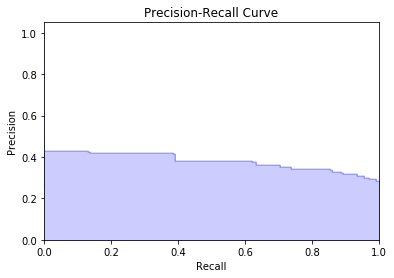

In [47]:
classifier = pipe.build_classifier('DecisionTree', x_train, y_train, max_depth = 5)

# draw precision-recall curve for this model
pipe.draw_precision_recall_curve(classifier, x_test, y_test)

### Run all the models

Note that this is time-consuming - uncomment at your own risk.

In [11]:
# pipe.test_over_time(proj, features, 'not_funded', 'interval', 'date_posted', lag_time=lag_time,
#                     to_file = 'run_all.csv', classifier_dict = pipe.CLASSIFIERS)

Beginning classifier type DecisionTree
Beginning classifier type KNN
Beginning classifier type LogisticRegression


/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Defau

Beginning classifier type SVM


/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Beginning classifier type BA
Beginning classifier type GB
Beginning classifier type RandomForest
Beginning classifier type DecisionTree
Beginning classifier type KNN
Beginning classifier type LogisticRegression


/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Defau

Beginning classifier type SVM


/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Beginning classifier type BA
Beginning classifier type GB
Beginning classifier type RandomForest
Beginning classifier type DecisionTree
Beginning classifier type KNN
Beginning classifier type LogisticRegression


/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Defau

Beginning classifier type SVM


/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Beginning classifier type BA
Beginning classifier type GB
Beginning classifier type RandomForest


,Train/Test Split ID,classifier,params,Threshold,Accuracy,Precision,Recall,F1,AUC_ROC Score
0,0,DecisionTree,"{'criterion': 'gini', 'max_depth': 1}",0.01,0.713531,0.278905,0.009890,0.019102,0.499922
1,0,DecisionTree,"{'criterion': 'gini', 'max_depth': 1}",0.02,0.709413,0.286511,0.020319,0.037946,0.500220
2,0,DecisionTree,"{'criterion': 'gini', 'max_depth': 1}",0.05,0.697241,0.292901,0.051929,0.088218,0.501340
3,0,DecisionTree,"{'criterion': 'gini', 'max_depth': 1}",0.10,0.675728,0.288873,0.102420,0.151224,0.501686
4,0,DecisionTree,"{'criterion': 'gini', 'max_depth': 1}",0.20,0.630804,0.282128,0.200058,0.234108,0.500040
5,0,DecisionTree,"{'criterion': 'gini', 'max_depth': 1}",0.30,0.585901,0.279913,0.297731,0.288547,0.498420
6,0,DecisionTree,"{'criterion': 'gini', 'max_depth': 1}",0.50,0.500619,0.282666,0.501097,0.361443,0.500764
0,0,DecisionTree,"{'criterion': 'gini', 'max_depth': 3}",0.01,0.713267,0.265720,0.009422,0.018199,0.499597
1,0,DecisionTree,"{'criterion': 'gini', 'max_depth': 3}",0.02,0.709027,0.276876,0.019635,0.036670,0.499745
2,0,DecisionTree,"{'criterion': 'gini', 'max_depth': 3}",0.05,0.695963,0.280122,0.049664,0.084369,0.499762


In [37]:
results = pd.read_csv('output/run_all.csv')
results5 = results.loc[results['Threshold'] == 0.05]

In [41]:
metrics = ['classifier', 'params', 'Train/Test Split ID', 'Precision', 'Recall', 'Accuracy', 'ROC_AUC']
results5[metrics].groupby(['classifier', 'params', 'Train/Test Split ID']).mean()

Precision  \
classifier   params                                             Train/Test Split ID              
BA           {'n_estimators': 10}                               0                     0.278093   
                                                                1                     0.291135   
                                                                2                     0.280217   
             {'n_estimators': 25}                               0                     0.274848   
                                                                1                     0.307225   
                                                                2                     0.286102   
             {'n_estimators': 50}                               0                     0.274645   
                                                                1                     0.287492   
                                                                2                     0.300589   
DecisionTree {'criterion': 'entropy', 'max_depth': 10}          0                     0.284990   
                                                                1                     0.285974   
                                                                2                     0.276143   
             {'criterion': 'entropy', 'max_depth': 15}          0                     0.277485   
                                                                1                     0.307529   
                                                                2                     0.272974   
             {'criterion': 'entropy', 'max_depth': 1}           0                     0.286613   
                                                                1                     0.311779   
                                                                2                     0.298778   
             {'criterion': 'entropy', 'max_depth': 3}           0                     0.287830   
                                                                1                     0.306618   
                                                                2                     0.291535   
             {'criterion': 'entropy', 'max_depth': 5}           0                     0.287830   
                                                                1                     0.305404   
                                                                2                     0.296514   
             {'criterion': 'gini', 'max_depth': 10}             0                     0.282961   
                                                                1                     0.287492   
                                                                2                     0.277048   
             {'criterion': 'gini', 'max_depth': 15}             0                     0.282353   
                                                                1                     0.301154   
                                                                2                     0.279312   
...                                                                                        ...   
RandomForest {'criterion': 'gini', 'max_depth': 15, 'n_estim... 0                     0.286410   
                                                                1                     0.301761   
                                                                2                     0.270258   
             {'criterion': 'gini', 'max_depth': 15, 'n_estim... 0                     0.284178   
                                                                1                     0.299332   
                                                                2                     0.272069   
             {'criterion': 'gini', 'max_depth': 15, 'n_estim... 0                     0.287018   
                                                                1                     0.295993   
                                                                2  